# Notebook to pool lineprofiles, calculate peak distance and plot Histograms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imsave
from scipy import signal
from scipy import misc
import scipy.fftpack
from scipy import stats
from scipy import signal
import os

## Define Path and Files

In [2]:
path=r"enter folder path here" # enter path to parent folder. data for sigle experiments is stored in subfolders, e.g. N=3 --> 3 subfolders


folders=os.listdir(path)

allfiles=[]
folderlist=[]
files=[]
for i in folders:
    
    tmp=os.listdir(path+i)
    for f in tmp:
        if (".csv" in f)==True: 
            files=files+[f]
            folderlist=folderlist+[i]
allfiles=pd.DataFrame([folderlist,files]).T
allfiles.columns=["folder","file"]

# define splitting function

In [3]:
def split(matrix,identifyer,axis):
    splitted=matrix.filter(like=identifyer,axis=axis)
    return splitted

## Find Maxima

In [ ]:
distances=[]
foldercolumn=[]
filecolumn=[]
profilenumbercolumn=[]
fused=[]

counter=0
for j in range(0,len(allfiles["folder"])):

    name=path+allfiles["folder"]+"\\"+allfiles["file"]
    matrix=pd.read_csv(name[j])
    matrixY=split(matrix,"Y0",1)


    for i in range(0,matrixY.shape[1]):    
        trace=matrixY.T.values[i]
        maxima=np.array(signal.argrelmax(trace))[0]
        fig=plt.figure()
        if (len(maxima)>1):
            plt.scatter(maxima[0],trace[maxima[0]], s=600, c='red', marker='x')
            plt.scatter(maxima[1],trace[maxima[1]], s=600, c='red', marker='x') 
        plt.plot(trace)
        plt.title(name[j])
        plt.xlabel('pixels')
        plt.ylabel('intensity')
        plt.show()
        
        parent, child = os.path.split(path.strip("\\"))
        newPath=parent+"/analysis/"+"/singleTrace/"
        if (os.path.exists(newPath)==False):
            os.makedirs(newPath)
        fig.savefig(newPath+allfiles["folder"][j]+allfiles["file"][j]+str(round(i))+".png")
        if (len(maxima)>1):
            zwerg=maxima[1]-maxima[0]
        else:zwerg="NaN"
        distances=distances+[zwerg]
        foldercolumn=foldercolumn+[allfiles["folder"][j]]
        filecolumn=filecolumn+[allfiles["file"][j]]
        profilenumbercolumn=profilenumbercolumn+[i]
        fused=fused+[allfiles["file"][j]+allfiles["folder"][j]]
        
        counter=counter+1

# Extract Genotype from Names, calculate distance in µm and assemble dataframe

In [6]:
genotype=[]
for i in range(0,len(distances)):
    if ("_1_" in fused[i]
        or "_3_" in fused[i]
        
        or "_7_" in fused[i]
        or "_10_" in fused[i]
        or "_12_" in fused[i]
        or "_18_" in fused[i]
       ):
        #print(fused[i])
        genotype=genotype+["WT"]
    if ("_2_" in fused[i]
        or "_4_" in fused[i]
        or "_6_" in fused[i]
        
        or "_9_" in fused[i]
        or "_11_" in fused[i]
        or "_408_" in fused[i]
       ):      
        genotype=genotype+["KO"]

In [7]:
pixsize=0.025
umdistances=[]
for i in distances:
    if (i!="NaN"):
        umdistances=umdistances+[i*pixsize]
    else:
        umdistances=umdistances+[np.nan]
output=pd.DataFrame([foldercolumn,filecolumn,profilenumbercolumn,genotype,distances,umdistances]).T
output.columns=["date","title","number","genotype","distance (pixels)","distance (µm)"]
output.to_csv(parent+"\\measurements.xls",sep="\t")
output.head()

,date,title,number,genotype,distance (pixels),distance (µm)
0,Results_20190321_CA1,Values_20190321_009_2_1.csv,0,KO,8,0.2
1,Results_20190321_CA1,Values_20190321_009_2_2.csv,0,KO,NaN,NaN
2,Results_20190321_CA1,Values_20190321_009_2_3.csv,0,KO,4,0.1
3,Results_20190321_CA1,Values_20190321_009_2_4.csv,0,KO,5,0.125
4,Results_20190321_CA1,Values_20190321_009_2_5.csv,0,KO,5,0.125


In [8]:
mice=["_1_","_2_","_3_","_4_","_6_","_7_","_9_","_10_","_11_","_12_","_408_","_18_"]

mouseStats=[["mouse","mean","std","sem","median"]]


stats=[]
for m in mice:
    stats=output[output["title"].str.contains(m)]  
    
    mouseStats=mouseStats+[[m,
                            stats["distance (µm)"].mean(),
                           stats["distance (µm)"].std(),
                           stats["distance (µm)"].sem(),
                           stats["distance (µm)"].median()]
                          
                          
                          
                          ]
mouseStats=pd.DataFrame(mouseStats)
mouseStats.to_csv(parent+"\\mouseStats.xls",sep="\t", header=False,index=False)

# Divide Dataset into WT vs KO

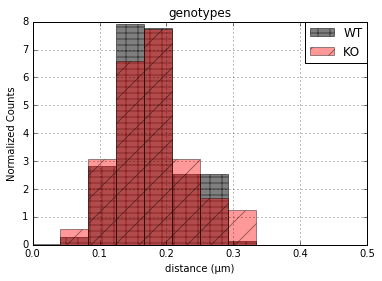

In [9]:
tmp=output
WT=tmp[output["genotype"]=="WT"]
KO=tmp[output["genotype"]=="KO"]

bins=np.linspace(0,0.5,13)
fig=plt.figure()
WT["distance (µm)"].hist(color="black", alpha=0.5, hatch="+-", label ="WT", bins=bins,normed=True)
KO["distance (µm)"].hist(color="red", alpha=0.4, hatch="/", edgecolor="black" ,label="KO",bins=bins,normed=True)
plt.title("genotypes")
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
plt.xlabel('distance (µm)')
plt.ylabel('Normalized Counts')
plt.show()
fig.savefig(parent+"\\histogram_WT-KO.png")
fig.savefig(parent+"\\cross-channel distance (µm).eps", format='eps')
fig.savefig(parent+"\\cross-channel distance (µm).pdf", format='pdf')